In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


2024-06-16 00:04:39.325322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 00:04:39.376491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 00:04:40.365886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(155, 220))
        if img is not None:
            images.append(img_to_array(img))
    return np.array(images)

def load_dataset(main_directory):
    forge_images = []
    real_images = []
    for i in range(1, 5):
        forge_folder = os.path.join(main_directory, f'dataset{i}', 'forge')
        real_folder = os.path.join(main_directory, f'dataset{i}', 'real')
        forge_images.extend(load_images_from_folder(forge_folder))
        real_images.extend(load_images_from_folder(real_folder))
    forge_images = np.array(forge_images)
    real_images = np.array(real_images)
    labels = np.array([0]*len(forge_images) + [1]*len(real_images))
    images = np.concatenate((forge_images, real_images), axis=0)
    return images, labels

dataset_dir = "Dataset"
images, labels = load_dataset(dataset_dir)
images = images / 255.0  # Normalize images

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [4]:
def build_signet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    model = Model(inputs, x)
    return model

input_shape = (155, 220, 1)
sig_model = build_signet_model(input_shape)


2024-06-16 00:05:41.490940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 00:05:41.577411: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
def siamese_model(base_model, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([processed_a, processed_b])

    prediction = Dense(1, activation='sigmoid')(L1_distance)
    model = Model(inputs=[input_a, input_b], outputs=prediction)
    return model

siamese_net = siamese_model(sig_model, input_shape)

siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Generating pairs
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        
        neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
        idxB = np.random.choice(idx[neg_label])
        neg_image = images[idxB]

        pair_images.append([current_image, neg_image])
        pair_labels.append([0])
    
    return np.array(pair_images), np.array(pair_labels)

pairs_train, labels_train = make_pairs(X_train, y_train)
pairs_test, labels_test = make_pairs(X_test, y_test)

siamese_net.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test), batch_size=32, epochs=10)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 463ms/step - accuracy: 0.5422 - loss: 0.7261 - val_accuracy: 0.4896 - val_loss: 0.6931
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - accuracy: 0.5078 - loss: 0.6935 - val_accuracy: 0.4965 - val_loss: 0.6931
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - accuracy: 0.5020 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 461ms/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.5104 - val_loss: 0.6930
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - accuracy: 0.5016 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 462ms/step - accuracy: 0.5037 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - accuracy: 0.4719 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accu

In [6]:
siamese_net.save('signet_model.h5')

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(155, 220,1))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

model = load_model('signet_model.h5')

def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    prediction = model.predict([img1, img2])
    return prediction[0][0] * 100

fake_img_path = 'signature1.jpeg'
real_img_path = 'signature2.png'
genuineness = evaluate_signature(fake_img_path, real_img_path)
print(f"Genuineness: {genuineness:.2f}%")

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_173>', '<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_175>'],)
  • kwargs={'mask': ['None', 'None']}

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(155, 220))
        if img is not None:
            images.append(img_to_array(img))
    return np.array(images)

# Function to load the dataset
def load_dataset(main_directory):
    forge_images = []
    real_images = []
    for i in range(1, 5):
        forge_folder = os.path.join(main_directory, f'dataset{i}', 'forge')
        real_folder = os.path.join(main_directory, f'dataset{i}', 'real')
        forge_images.extend(load_images_from_folder(forge_folder))
        real_images.extend(load_images_from_folder(real_folder))
    forge_images = np.array(forge_images)
    real_images = np.array(real_images)
    labels = np.array([0]*len(forge_images) + [1]*len(real_images))
    images = np.concatenate((forge_images, real_images), axis=0)
    return images, labels

# Load and normalize the dataset
dataset_dir = "Dataset"
images, labels = load_dataset(dataset_dir)
images = images / 255.0  # Normalize images

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Function to build the Signet model
def build_signet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model

input_shape = (155, 220, 1)
sig_model = build_signet_model(input_shape)

# Function to build the Siamese network
def siamese_model(base_model, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=lambda input_shapes: input_shapes[0])
    L1_distance = L1_layer([processed_a, processed_b])
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    model = Model(inputs=[input_a, input_b], outputs=prediction)
    return model

siamese_net = siamese_model(sig_model, input_shape)
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Function to generate pairs of images for training
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
        idxB = np.random.choice(idx[neg_label])
        neg_image = images[idxB]
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])
    return np.array(pair_images), np.array(pair_labels)

pairs_train, labels_train = make_pairs(X_train, y_train)
pairs_test, labels_test = make_pairs(X_test, y_test)

# Train the model
siamese_net.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test), batch_size=32, epochs=10)
siamese_net.save('signet_model.h5')

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(155, 220))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

model = load_model('signet_model.h5', custom_objects={'tf': tf})

# Function to evaluate the genuineness of two signatures
def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    prediction = model.predict([img1, img2])
    return prediction[0][0] * 100

# Example usage


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - accuracy: 0.4624 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - accuracy: 0.4821 - loss: 0.6935 - val_accuracy: 0.4826 - val_loss: 0.6932
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 449ms/step - accuracy: 0.4995 - loss: 0.6933 - val_accuracy: 0.5104 - val_loss: 0.6931
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.5180 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step - accuracy: 0.5055 - loss: 0.6932 - val_accuracy: 0.5104 - val_loss: 0.6932
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.5022 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step - accuracy: 0.4915 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 443ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accu

FileNotFoundError: [Errno 2] No such file or directory: 'signature2.png'

In [10]:
# Custom function for the Lambda layer
def custom_abs_diff(tensors):
    x, y = tensors
    return tf.abs(x - y)
# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(155, 220))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Ensure custom Lambda function is registered during model loading
custom_objects = {'custom_abs_diff': custom_abs_diff}

model = load_model('signet_model.h5', custom_objects=custom_objects)

# Function to evaluate the genuineness of two signatures
def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    prediction = model.predict([img1, img2])
    return prediction[0][0] * 100

# Example usage
fake_img_path = 'signature1.jpeg'
real_img_path = 'signature2.jpeg'
genuineness = evaluate_signature(fake_img_path, real_img_path)
print(f"Genuineness: {genuineness:.2f}%")

NameError: Exception encountered when calling Lambda.call().

[1mname 'tf' is not defined[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(1, 128), dtype=float32)', 'tf.Tensor(shape=(1, 128), dtype=float32)']
  • mask=['None', 'None']
  • training=False

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 450ms/step - accuracy: 0.4739 - loss: 0.7110 - val_accuracy: 0.4861 - val_loss: 0.6932
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.4960 - loss: 0.6937 - val_accuracy: 0.5208 - val_loss: 0.6931
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 449ms/step - accuracy: 0.4748 - loss: 0.6932 - val_accuracy: 0.4965 - val_loss: 0.6932
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.5097 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.5084 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.4814 - loss: 0.6951 - val_accuracy: 0.4896 - val_loss: 0.6940
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 443ms/step - accuracy: 0.5068 - loss: 0.6935 - val_accuracy: 0.4965 - val_loss: 0.6932
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.5277 - loss: 0.6954 - val_accu

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(155, 220))
        if img is not None:
            images.append(img_to_array(img))
    return np.array(images)

# Function to load the dataset
def load_dataset(main_directory):
    forge_images = []
    real_images = []
    for i in range(1, 5):
        forge_folder = os.path.join(main_directory, f'dataset{i}', 'forge')
        real_folder = os.path.join(main_directory, f'dataset{i}', 'real')
        forge_images.extend(load_images_from_folder(forge_folder))
        real_images.extend(load_images_from_folder(real_folder))
    forge_images = np.array(forge_images)
    real_images = np.array(real_images)
    labels = np.array([0]*len(forge_images) + [1]*len(real_images))
    images = np.concatenate((forge_images, real_images), axis=0)
    return images, labels

# Load and normalize the dataset
dataset_dir = "Dataset"
images, labels = load_dataset(dataset_dir)
images = images / 255.0  # Normalize images

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Function to build the Signet model
def build_signet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model

input_shape = (155, 220, 1)
sig_model = build_signet_model(input_shape)

# Custom function for the Lambda layer
def custom_abs_diff(tensors):
    x, y = tensors
    return tf.abs(x - y)

# Function to build the Siamese network
def siamese_model(base_model, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    L1_layer = Lambda(custom_abs_diff)
    L1_distance = L1_layer([processed_a, processed_b])
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    model = Model(inputs=[input_a, input_b], outputs=prediction)
    return model

siamese_net = siamese_model(sig_model, input_shape)
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Function to generate pairs of images for training
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append(1)
        neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
        idxB = np.random.choice(idx[neg_label])
        neg_image = images[idxB]
        pair_images.append([current_image, neg_image])
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

pairs_train, labels_train = make_pairs(X_train, y_train)
pairs_test, labels_test = make_pairs(X_test, y_test)

# Train the model
siamese_net.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test), batch_size=32, epochs=10)
siamese_net.save('signet_model.keras')

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(155, 220))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Ensure custom Lambda function is registered during model loading
custom_objects = {'custom_abs_diff': custom_abs_diff}

# Load the model with custom objects
model = load_model('signet_model.keras', custom_objects=custom_objects, compile=False)

# Function to evaluate the genuineness of two signatures
def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    prediction = model.predict([img1, img2])
    return prediction[0][0] * 100




ValueError: Argument(s) not recognized: {'lr': 0.0001}

In [19]:
# Example usage
fake_img_path = 'signature1.jpeg'
real_img_path = 'signature3.jpeg'
genuineness = evaluate_signature(fake_img_path, real_img_path)
print(f"Genuineness: {genuineness:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Genuineness: 50.12%


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
def load_images_from_folder(folder, augmentation=False):
    images = []
    if augmentation:
        datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                     shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
        for filename in os.listdir(folder):
            img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(155, 220))
            if img is not None:
                img = img_to_array(img)
                img = np.expand_dims(img, axis=0)
                for batch in datagen.flow(img, batch_size=1):
                    images.append(batch[0])
                    break
    else:
        for filename in os.listdir(folder):
            img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(155, 220))
            if img is not None:
                images.append(img_to_array(img))
    return np.array(images)


def load_datasets(main_directories, augmentation=False):
    all_images = []
    all_labels = []
    for main_directory in main_directories:
        forge_images = []
        real_images = []
        datasets = ['dataset1', 'dataset2', 'dataset3', 'dataset4']
        for dataset in datasets:
            forge_folder = os.path.join(main_directory, dataset, 'forge')
            real_folder = os.path.join(main_directory, dataset, 'real')
            forge_images.extend(load_images_from_folder(forge_folder, augmentation))
            real_images.extend(load_images_from_folder(real_folder, augmentation))
        forge_images = np.array(forge_images)
        real_images = np.array(real_images)
        labels = np.array([0] * len(forge_images) + [1] * len(real_images))
        images = np.concatenate((forge_images, real_images), axis=0)
        all_images.append(images)
        all_labels.append(labels)
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_images, all_labels


# Define main directories where datasets are located
main_directories = [
    "archive (1)/Dataset_Signature_Final/Dataset",
    "archive (1)/dataset_signature_final/Dataset"
]
images, labels = load_datasets(main_directories, augmentation=True)
images = images / 255.0  # Normalize images

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Function to build the Signet model with enhancements
def build_signet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (11, 11), strides=(4, 4), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model

input_shape = (155, 220, 1)
sig_model = build_signet_model(input_shape)

# Custom function for the Lambda layer
def custom_abs_diff(tensors):
    x, y = tensors
    return tf.abs(x - y)

def siamese_model(base_model, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    L1_layer = Lambda(custom_abs_diff)([processed_a, processed_b])
    prediction = Dense(1, activation='sigmoid')(L1_layer)
    model = Model(inputs=[input_a, input_b], outputs=prediction)
    return model


siamese_net = siamese_model(sig_model, input_shape)
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Function to generate pairs of images for training
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        # Positive Pair
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append(1)
        # Negative Pair
        neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
        idxB = np.random.choice(idx[neg_label])
        neg_image = images[idxB]
        pair_images.append([current_image, neg_image])
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

pairs_train, labels_train = make_pairs(X_train, y_train)
pairs_val, y_val = make_pairs(X_val, y_val)
pairs_test, labels_test = make_pairs(X_test, y_test)

# Enhanced training with callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00003)
history = siamese_net.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train, 
    validation_data=([pairs_val[:, 0], pairs_val[:, 1]], y_val), 
    batch_size=32, epochs=50, 
    callbacks=[early_stopping, reduce_lr]
)

siamese_net.save('signet_model_augmented.keras')

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(155, 220))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Ensure custom Lambda function is registered during model loading
custom_objects = {'custom_abs_diff': custom_abs_diff}

# Load the model with custom objects
model = load_model('signet_model_augmented.keras', custom_objects=custom_objects, compile=False)

# Function to evaluate the genuineness of two signatures
def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    prediction = model.predict([img1, img2])
    return prediction[0][0] * 100

2024-06-16 01:05:06.369221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 01:05:06.452947: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - accuracy: 0.4836 - loss: 0.9687 - val_accuracy: 0.5020 - val_loss: 0.7364 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.4895 - loss: 0.8973 - val_accuracy: 0.4918 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.5023 - loss: 0.8924 - val_accuracy: 0.5327 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.5167 - loss: 0.8365 - val_accuracy: 0.5102 - val_loss: 0.8145 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.4611 - loss: 0.8750 - val_accuracy: 0.4592 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 265ms/step - accuracy: 0.4885 - loss: 0.7901 - val_accuracy: 0.4490 - val_loss: 0.8208 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.5216 - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
fraud: 100.00%


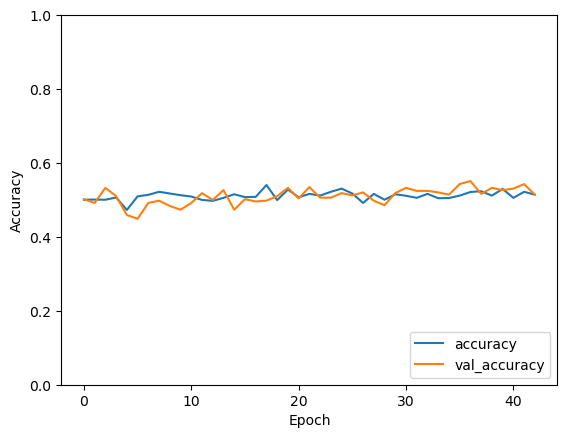

In [26]:
# Example usage
fake_img_path = 'fraud1.jpeg'
real_img_path = 'signature1.jpeg'
genuineness = evaluate_signature(fake_img_path, real_img_path)

if genuineness>75:
    print(f"fraud: {genuineness:.2f}%")
else:
    print("genuine")

# Evaluate training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()